# Modelos de Deep Learning

Laboratorio 03 – Deep Learning

Edwin Ortega 22305 - Esteban Zambrano 22119 - Diego García 22404

Link del repositorio:<br>
https://github.com/EstebanZG999/Lab3_DS

### Imports

In [9]:
import os
import numpy as np
import pandas as pd
import cv2
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.utils import Sequence, to_categorical
from sklearn.model_selection import train_test_split

### Verifica entorno

In [3]:
# Verifica CUDA disponible
print("¿CUDA disponible?:", torch.cuda.is_available())

# Verifica GPU
if torch.cuda.is_available():
    print("GPU detectada:", torch.cuda.get_device_name(0))

¿CUDA disponible?: False


### Preprocesamiento y Dataset

In [4]:
class PolyMNISTDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Dataset personalizado para PolyMNIST.
        - root_dir: carpeta raíz que contiene subcarpetas m0, m1, ..., m4.
        - transform: transformaciones a aplicar a cada imagen.
        """
        self.image_paths = []
        self.labels = []
        self.transform = transform

        for label in range(5):  # m0 = 0, m1 = 1, ..., m4 = 4
            class_dir = os.path.join(root_dir, f"m{label}")
            for img_name in os.listdir(class_dir):
                if img_name.endswith(".png"):
                    self.image_paths.append(os.path.join(class_dir, img_name))
                    self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        image = Image.open(img_path).convert("L")  # convertir a escala de grises
        if self.transform:
            image = self.transform(image)

        return image, label


Cargar el dataset y crear el DataLoader

In [5]:
# Definir transformaciones
transform = transforms.Compose([
    transforms.Resize((28, 28)),       # Asegura tamaño uniforme
    transforms.ToTensor(),             # Convierte a tensor (C, H, W)
    transforms.Normalize((0.5,), (0.5,))  # Normaliza a [-1, 1]
])

# Dataset y DataLoader
train_dir = "../data/PolyMNIST/MMNIST/train"
train_dataset = PolyMNISTDataset(root_dir=train_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Verifica que funciona
images, labels = next(iter(train_loader))
print(f"Shape batch imágenes: {images.shape}")  # Esperado: (64, 1, 28, 28)
print(f"Labels: {labels[:10]}")


Shape batch imágenes: torch.Size([64, 1, 28, 28])
Labels: tensor([4, 3, 0, 4, 2, 3, 2, 4, 3, 0])


GPU Check en el loader

In [6]:
# GPU Check en el loader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Entrenando en:", device)

# Mover un batch de prueba a GPU
images, labels = next(iter(train_loader))
images, labels = images.to(device), labels.to(device)
print("Datos en GPU:", images.device)

Entrenando en: cpu
Datos en GPU: cpu


### Primer Modelo - CNN 

In [7]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Reducción de tamaño a la mitad
        self.fc1 = nn.Linear(32 * 7 * 7, 128)  # Flatten final
        self.fc2 = nn.Linear(128, 5)  # 5 clases: m0 a m4

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [1, 28, 28] -> [16, 14, 14]
        x = self.pool(F.relu(self.conv2(x)))  # [16, 14, 14] -> [32, 7, 7]
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

##### Entrenaiento primer modelo

In [8]:
# Función de pérdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Bucle de entrenamiento
epochs = 5
for epoch in range(1, epochs+1):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc  = correct / total
    print(f"Época {epoch}/{epochs} — Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

# Evaluación en el set de test
model.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_loss /= total
test_acc  = correct / total
print(f"\n— Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

# Guarda el modelo entrenado
torch.save(model.state_dict(), "cnn_polymnist_m0-4.pth")
print("\nModelo guardado como cnn_polymnist_m0-4.pth")

NameError: name 'model' is not defined

### Modelo de Redes Neuronales

In [10]:
class PolyMNISTGenerator(Sequence):
    def __init__(self, file_list, batch_size=64, img_size=(28, 28), shuffle=True):
        self.file_list = file_list  # lista de (ruta_completa, nombre_archivo)
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.file_list) / self.batch_size))

    def __getitem__(self, index):
        batch_files = self.file_list[index*self.batch_size:(index+1)*self.batch_size]
        X = np.zeros((len(batch_files), *self.img_size, 1), dtype='float32')
        y = np.zeros((len(batch_files), 10), dtype='float32')

        for i, (full_path, fname) in enumerate(batch_files):
            img = cv2.imread(full_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, self.img_size)
            img = img.astype('float32') / 255.0
            X[i] = img.reshape(*self.img_size, 1)

            label = int(os.path.splitext(fname)[0].split('.')[1])
            y[i] = to_categorical(label, num_classes=10)

        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.file_list)


In [11]:
def collect_files(base_dir, modalities=["m0", "m1", "m2", "m3", "m4"]):
    file_list = []
    for mod in modalities:
        mod_path = os.path.join(base_dir, mod)
        for fname in os.listdir(mod_path):
            if fname.endswith('.png'):
                full_path = os.path.join(mod_path, fname)
                file_list.append((full_path, fname))
    return file_list

# Ruta base
BASE_DIR = "../data/PolyMNIST/MMNIST/train"

# Recolectar todos los archivos
all_files = collect_files(BASE_DIR)

# Dividir en train/val
train_files, val_files = train_test_split(all_files, test_size=0.2, random_state=42)

# Crear generadores
train_gen = PolyMNISTGenerator(train_files, batch_size=64)
val_gen = PolyMNISTGenerator(val_files, batch_size=64, shuffle=False)


In [12]:
RNModel = models.Sequential([
    layers.Input(shape=(28, 28, 1)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])


In [13]:
RNModel.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = RNModel.fit(train_gen,
                    epochs=5,
                    validation_data=val_gen)


c:\Users\dgv31\OneDrive\Documents\Universidad\Semestre 8\data science\Lab2_DS\tf_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 214s 57ms/step - accuracy: 0.4658 - loss: 1.5911 - val_accuracy: 0.7046 - val_loss: 0.9607
Epoch 2/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 125s 33ms/step - accuracy: 0.7046 - loss: 0.9371 - val_accuracy: 0.7515 - val_loss: 0.8149
Epoch 3/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 111s 30ms/step - accuracy: 0.7476 - loss: 0.8058 - val_accuracy: 0.7580 - val_loss: 0.7760
Epoch 4/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 112s 30ms/step - accuracy: 0.7669 - loss: 0.7472 - val_accuracy: 0.7666 - val_loss: 0.7541
Epoch 5/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 119s 32ms/step - accuracy: 0.7779 - loss: 0.7137 - val_accuracy: 0.7915 - val_loss: 0.6916


938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.7921 - loss: 0.6893
Precisión en validación: 79.15%


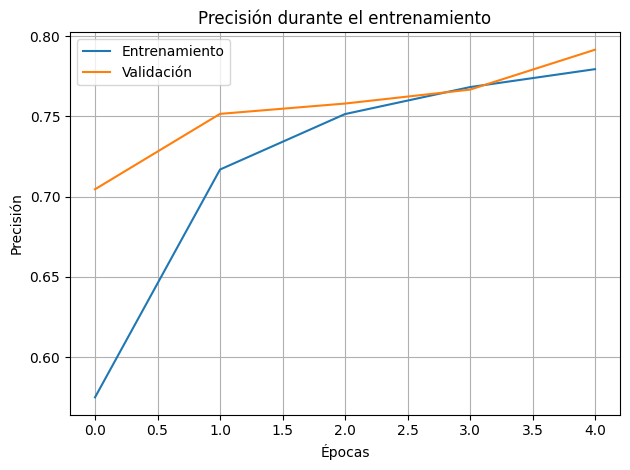

In [14]:
val_loss, val_acc = RNModel.evaluate(val_gen)
print(f"Precisión en validación: {val_acc*100:.2f}%")

plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
